# CNN Network Implementation 

**Dataset**: CIFAR-10 (60,000 32x32 color images in 10 classes)

**Assignment Objectives**:
1. Implement 6+ different CNN topologies
2. Evaluate and compare architectures  
3. Generate confusion matrices for top 2 models
4. Statistical comparison (McNemar's test) between best models
5. Compare CNN vs MLP: accuracy vs parameters

In [24]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from statsmodels.stats.contingency_tables import mcnemar
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)
Number of classes: 10
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)
Number of classes: 10


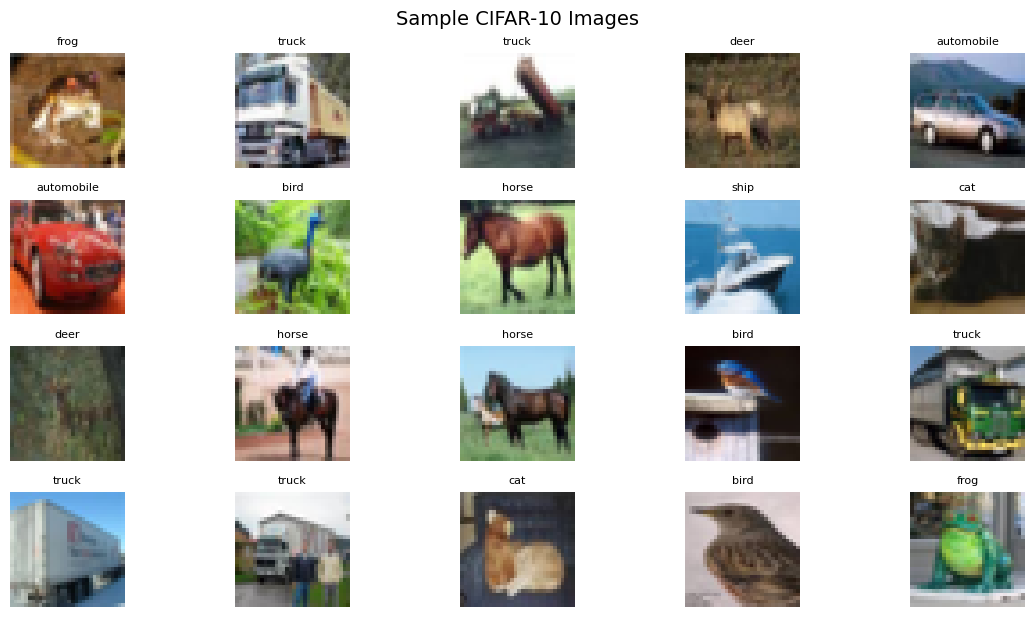

In [3]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Display dataset information
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Number of classes: {len(class_names)}")

# Visualize some samples
plt.figure(figsize=(12, 6))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i][0]], fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Sample CIFAR-10 Images', y=1.02, fontsize=14)
plt.show()

In [4]:
# Normalize pixel values to [0, 1]
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train_categorical = to_categorical(y_train, 10)
y_test_categorical = to_categorical(y_test, 10)

# For MLP comparison, flatten the images
X_train_flat = X_train_normalized.reshape(X_train_normalized.shape[0], -1)
X_test_flat = X_test_normalized.reshape(X_test_normalized.shape[0], -1)

print(f"Normalized training data range: [{X_train_normalized.min()}, {X_train_normalized.max()}]")
print(f"Flattened data shape for MLP: {X_train_flat.shape}")
print(f"One-hot encoded labels shape: {y_train_categorical.shape}")

Normalized training data range: [0.0, 1.0]
Flattened data shape for MLP: (50000, 3072)
One-hot encoded labels shape: (50000, 10)


In [5]:
def create_simple_cnn():
    """Simple CNN - 2 convolutional layers"""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

def create_lenet_style():
    """LeNet-style architecture"""
    model = models.Sequential([
        layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(16, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(120, activation='relu'),
        layers.Dense(84, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

def create_medium_cnn():
    """Medium CNN - 3 convolutional blocks"""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

def create_vgg_style():
    """VGG-style - Deeper network with small kernels"""
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

def create_deep_cnn_dropout():
    """Deep CNN with Dropout for regularization"""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

def create_inception_style():
    """Inception-style with multi-scale feature extraction"""
    input_layer = layers.Input(shape=(32, 32, 3))
    
    # First conv block
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Inception-like module
    tower_1 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(x)
    tower_1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(tower_1)
    
    tower_2 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(x)
    tower_2 = layers.Conv2D(32, (5, 5), padding='same', activation='relu')(tower_2)
    
    tower_3 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    tower_3 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(tower_3)
    
    x = layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Final conv layers
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(10, activation='softmax')(x)
    
    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

print("All CNN architectures defined successfully!")

All CNN architectures defined successfully!


In [6]:
def create_mlp():
    """Multi-Layer Perceptron for comparison"""
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=(3072,)),  # 32*32*3 = 3072
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

print("MLP architecture defined!")

MLP architecture defined!


In [7]:
# Dictionary to store all models
models_dict = {
    'Simple CNN': create_simple_cnn(),
    'LeNet-style': create_lenet_style(),
    'Medium CNN': create_medium_cnn(),
    'VGG-style': create_vgg_style(),
    'Deep CNN + Dropout': create_deep_cnn_dropout(),
    'Inception-style': create_inception_style()
}

# Function to count parameters
def count_parameters(model):
    return model.count_params()

# Display model summaries and parameter counts
print("=" * 80)
print("MODEL ARCHITECTURES AND PARAMETER COUNTS")
print("=" * 80)

for name, model in models_dict.items():
    params = count_parameters(model)
    print(f"\n{name}: {params:,} parameters")
    
print("\n" + "=" * 80)

MODEL ARCHITECTURES AND PARAMETER COUNTS

Simple CNN: 167,562 parameters

LeNet-style: 62,006 parameters

Medium CNN: 402,986 parameters

VGG-style: 2,228,426 parameters

Deep CNN + Dropout: 845,738 parameters

Inception-style: 413,226 parameters



In [8]:
# Training configuration
EPOCHS = 30
BATCH_SIZE = 64

# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Dictionary to store results
results = {}
histories = {}

# Train all CNN models
print("Training CNN models...\n")
for name, model in models_dict.items():
    print(f"\n{'='*80}")
    print(f"Training: {name}")
    print(f"{'='*80}")
    
    # Compile model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train model
    history = model.fit(X_train_normalized, y_train_categorical,
                       epochs=EPOCHS,
                       batch_size=BATCH_SIZE,
                       validation_split=0.2,
                       callbacks=[early_stopping, reduce_lr],
                       verbose=1)
    
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test_normalized, y_test_categorical, verbose=0)
    
    # Get predictions
    y_pred = model.predict(X_test_normalized, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Store results
    results[name] = {
        'model': model,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'parameters': count_parameters(model),
        'predictions': y_pred_classes,
        'history': history.history
    }
    histories[name] = history
    
    print(f"\n{name} - Test Accuracy: {test_acc:.4f}, Parameters: {count_parameters(model):,}")

print("\n" + "="*80)
print("All CNN models trained!")
print("="*80)

Training CNN models...


Training: Simple CNN
Epoch 1/30
Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.4314 - loss: 1.5726 - val_accuracy: 0.5385 - val_loss: 1.3064 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.4314 - loss: 1.5726 - val_accuracy: 0.5385 - val_loss: 1.3064 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.5652 - loss: 1.2258 - val_accuracy: 0.5889 - val_loss: 1.1694 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.5652 - loss: 1.2258 - val_accuracy: 0.5889 - val_loss: 1.1694 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.6152 - loss: 1.0950 - val_accuracy: 0.6170 - val_loss: 1.0934 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.6152 - loss: 1.0950 - val_accuracy: 0.6170 - val_loss: 1.0934 - learning_rate: 0.0010
Epoch 4/30
625/625 

In [9]:
# Train MLP for comparison
print("\nTraining MLP model...")
print("="*80)

mlp_model = create_mlp()
mlp_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

mlp_history = mlp_model.fit(X_train_flat, y_train_categorical,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_split=0.2,
                            callbacks=[early_stopping, reduce_lr],
                            verbose=1)

# Evaluate MLP
mlp_test_loss, mlp_test_acc = mlp_model.evaluate(X_test_flat, y_test_categorical, verbose=0)
mlp_y_pred = mlp_model.predict(X_test_flat, verbose=0)
mlp_y_pred_classes = np.argmax(mlp_y_pred, axis=1)

results['MLP'] = {
    'model': mlp_model,
    'test_accuracy': mlp_test_acc,
    'test_loss': mlp_test_loss,
    'parameters': count_parameters(mlp_model),
    'predictions': mlp_y_pred_classes,
    'history': mlp_history.history
}

print(f"\nMLP - Test Accuracy: {mlp_test_acc:.4f}, Parameters: {count_parameters(mlp_model):,}")
print("="*80)


Training MLP model...
Epoch 1/30
Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.1383 - loss: 2.2530 - val_accuracy: 0.1800 - val_loss: 2.1230 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.1383 - loss: 2.2530 - val_accuracy: 0.1800 - val_loss: 2.1230 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.1567 - loss: 2.1682 - val_accuracy: 0.1954 - val_loss: 2.0842 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.1567 - loss: 2.1682 - val_accuracy: 0.1954 - val_loss: 2.0842 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.1676 - loss: 2.1432 - val_accuracy: 0.2190 - val_loss: 2.0665 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.1676 - loss: 2.1432 - val_accuracy: 0.2190 - val_loss: 2.0665 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14m

In [22]:
# Create comparison table
comparison_data = []
for name, result in results.items():
    comparison_data.append({
        'Model': name,
        'Test Accuracy': f"{result['test_accuracy']:.4f}",
        'Test Loss': f"{result['test_loss']:.4f}",
        'Parameters': f"{result['parameters']:,}",
        'Accuracy (%)': f"{result['test_accuracy']*100:.2f}%"
    })

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "="*100)
print("MODEL PERFORMANCE COMPARISON")
print("="*100)
print(df_comparison.to_string(index=False))
print("="*100)

# Identify top 2 models
top_2_models = df_comparison.head(2)['Model'].values
print(f"\n Top 2 Models: {top_2_models[0]} and {top_2_models[1]}")
print("="*100)


MODEL PERFORMANCE COMPARISON
             Model Test Accuracy Test Loss Parameters Accuracy (%)
         VGG-style        0.7353    0.8076  2,228,426       73.53%
        Medium CNN        0.7304    0.8116    402,986       73.04%
        Simple CNN        0.6674    1.0231    167,562       66.74%
   Inception-style        0.5299    1.2976    413,226       52.99%
Deep CNN + Dropout        0.4463    1.4937    845,738       44.63%
       LeNet-style        0.4274    1.5834     62,006       42.74%
               MLP        0.1823    2.1195  1,738,890       18.23%

 Top 2 Models: VGG-style and Medium CNN


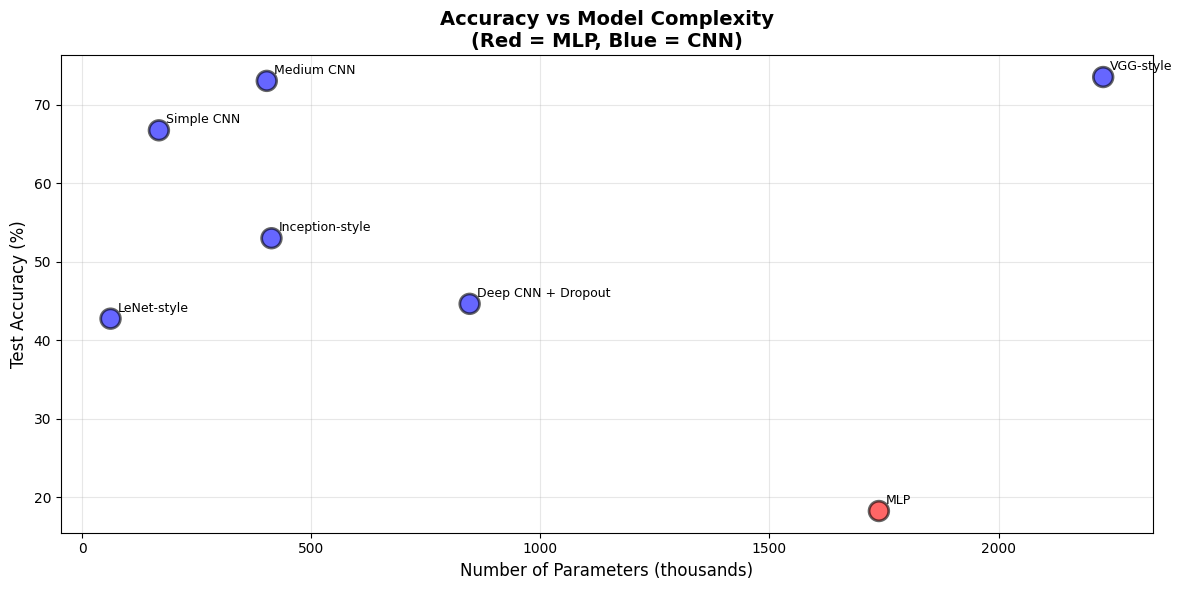

Key Insight: CNNs achieve better accuracy with fewer parameters compared to MLP!


In [11]:
# Visualize accuracy vs parameters
plt.figure(figsize=(12, 6))

models_list = list(results.keys())
accuracies = [results[m]['test_accuracy']*100 for m in models_list]
params = [results[m]['parameters']/1000 for m in models_list]  # in thousands

colors = ['red' if 'MLP' in m else 'blue' for m in models_list]

plt.scatter(params, accuracies, s=200, c=colors, alpha=0.6, edgecolors='black', linewidth=2)

for i, model_name in enumerate(models_list):
    plt.annotate(model_name, (params[i], accuracies[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('Number of Parameters (thousands)', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Accuracy vs Model Complexity\n(Red = MLP, Blue = CNN)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Key Insight: CNNs achieve better accuracy with fewer parameters compared to MLP!")

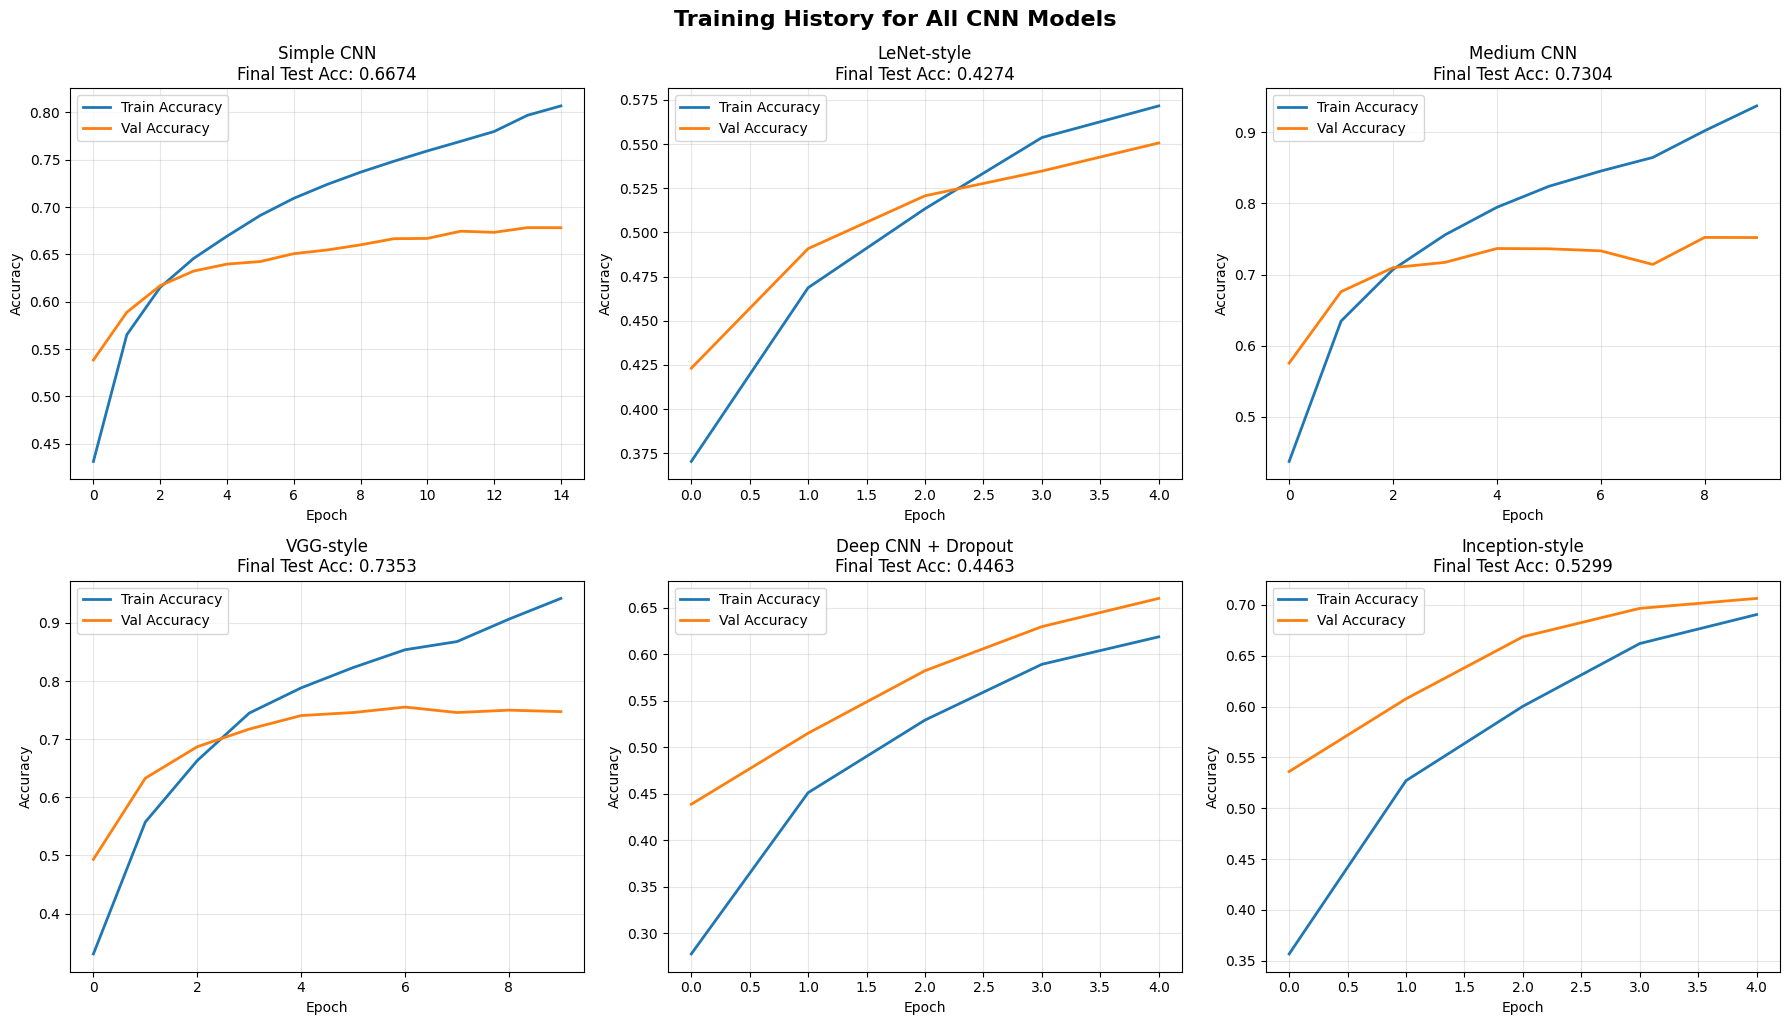

In [12]:
# Plot training histories
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

cnn_models = [m for m in results.keys() if m != 'MLP']

for idx, model_name in enumerate(cnn_models):
    history = results[model_name]['history']
    
    axes[idx].plot(history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[idx].plot(history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].set_title(f'{model_name}\nFinal Test Acc: {results[model_name]["test_accuracy"]:.4f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Training History for All CNN Models', fontsize=16, y=1.02, fontweight='bold')
plt.show()

Top Model 1: VGG-style - Accuracy: 0.7353
Top Model 2: Medium CNN - Accuracy: 0.7304


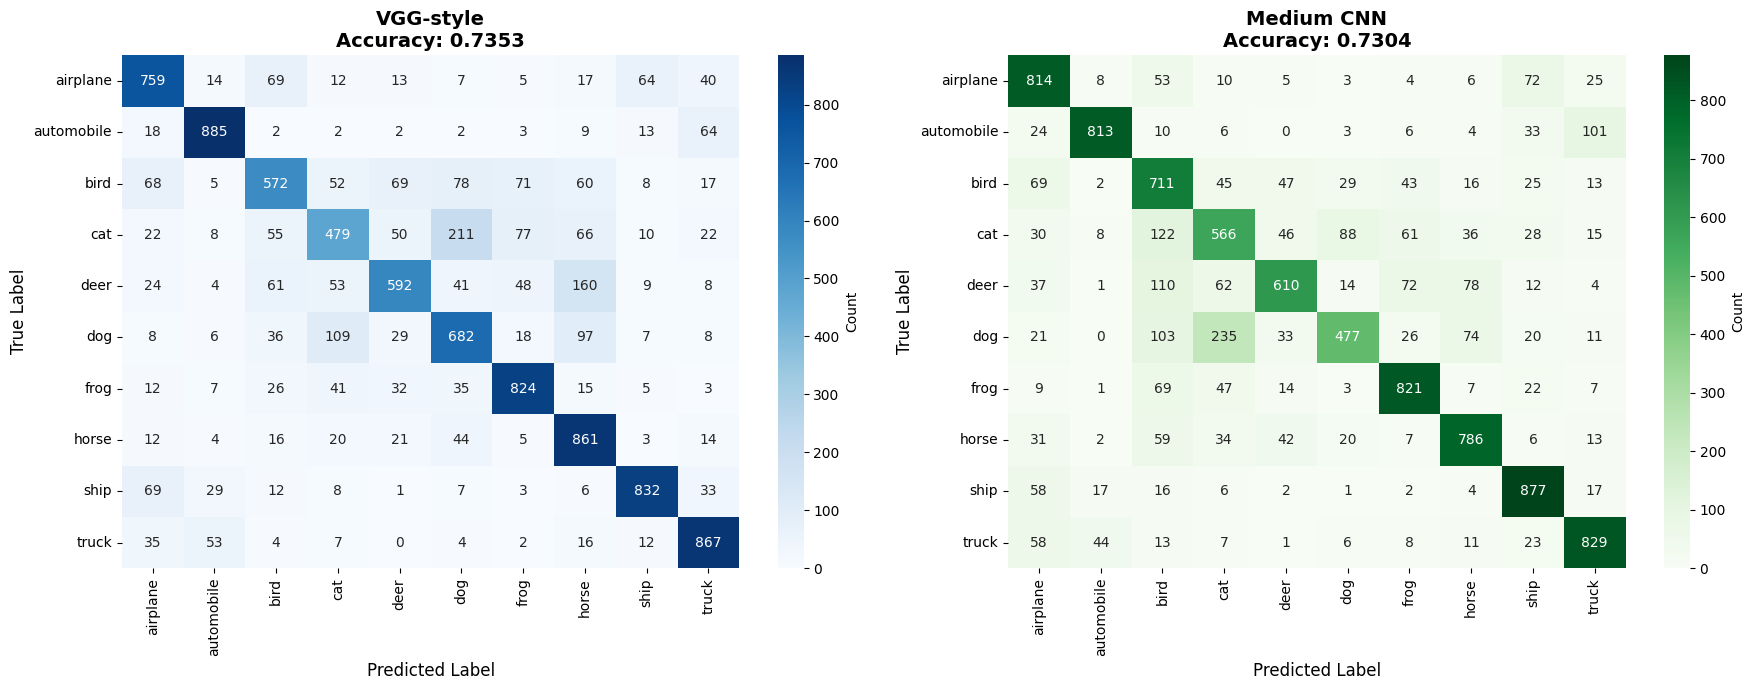

In [13]:
# Get top 2 models
sorted_models = sorted(results.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)
top_model_1_name, top_model_1_data = sorted_models[0]
top_model_2_name, top_model_2_data = sorted_models[1]

print(f"Top Model 1: {top_model_1_name} - Accuracy: {top_model_1_data['test_accuracy']:.4f}")
print(f"Top Model 2: {top_model_2_name} - Accuracy: {top_model_2_data['test_accuracy']:.4f}")

# Calculate confusion matrices
y_true = y_test.flatten()

cm_top1 = confusion_matrix(y_true, top_model_1_data['predictions'])
cm_top2 = confusion_matrix(y_true, top_model_2_data['predictions'])

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Top Model 1
sns.heatmap(cm_top1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_title(f'{top_model_1_name}\nAccuracy: {top_model_1_data["test_accuracy"]:.4f}', 
                  fontsize=14, fontweight='bold')

# Top Model 2
sns.heatmap(cm_top2, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_title(f'{top_model_2_name}\nAccuracy: {top_model_2_data["test_accuracy"]:.4f}', 
                  fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

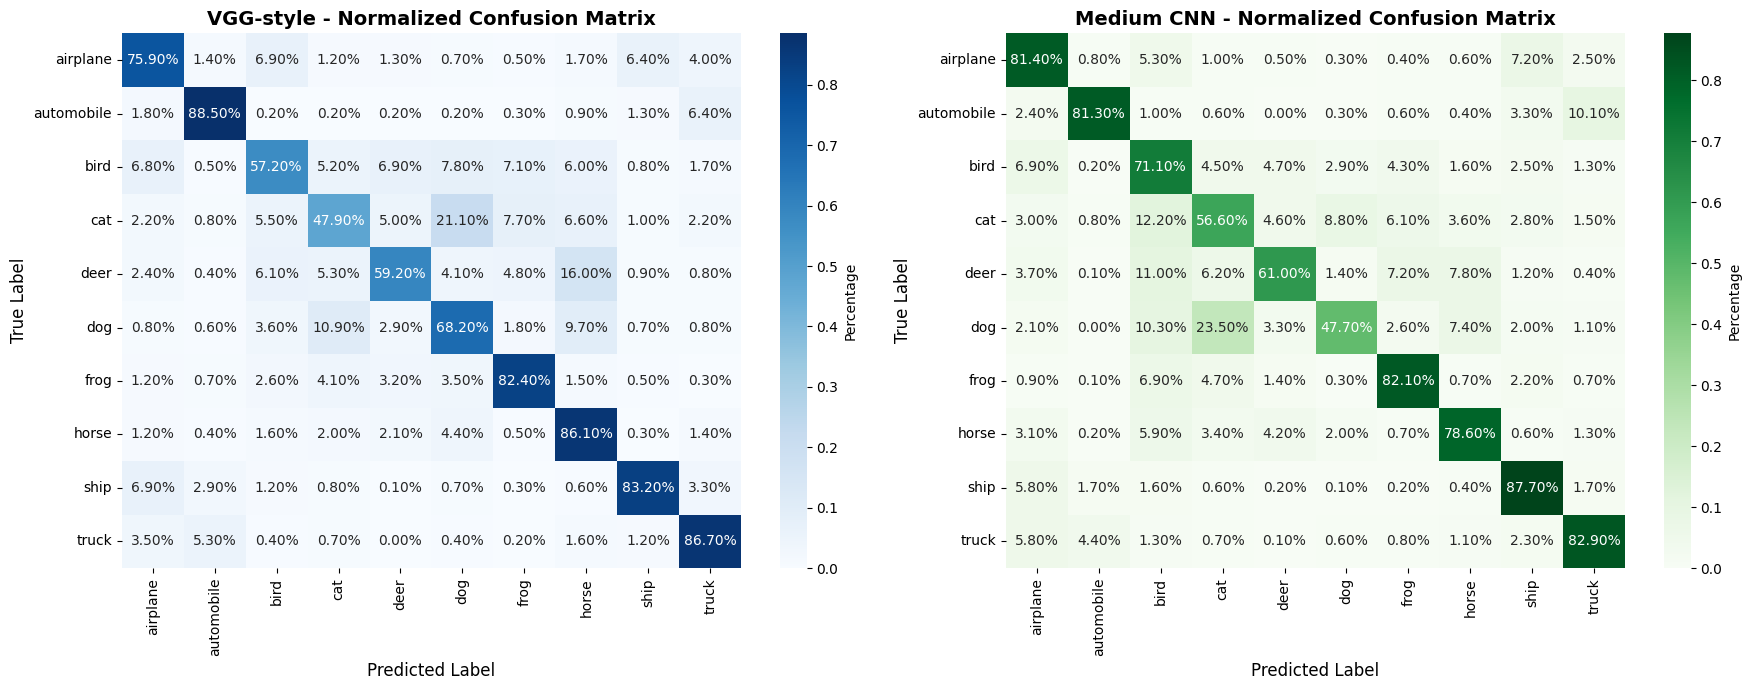

In [14]:
# Normalized confusion matrices (percentages)
cm_top1_norm = cm_top1.astype('float') / cm_top1.sum(axis=1)[:, np.newaxis]
cm_top2_norm = cm_top2.astype('float') / cm_top2.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Top Model 1 - Normalized
sns.heatmap(cm_top1_norm, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Percentage'})
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_title(f'{top_model_1_name} - Normalized Confusion Matrix', 
                  fontsize=14, fontweight='bold')

# Top Model 2 - Normalized
sns.heatmap(cm_top2_norm, annot=True, fmt='.2%', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_title(f'{top_model_2_name} - Normalized Confusion Matrix', 
                  fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [15]:
# McNemar's Test between top 2 models
pred_top1 = top_model_1_data['predictions']
pred_top2 = top_model_2_data['predictions']

# Create contingency table
# n00: both correct, n01: model1 correct, model2 wrong
# n10: model1 wrong, model2 correct, n11: both wrong
correct_top1 = (pred_top1 == y_true)
correct_top2 = (pred_top2 == y_true)

n00 = np.sum(correct_top1 & correct_top2)  # Both correct
n01 = np.sum(correct_top1 & ~correct_top2)  # Top1 correct, Top2 wrong
n10 = np.sum(~correct_top1 & correct_top2)  # Top1 wrong, Top2 correct
n11 = np.sum(~correct_top1 & ~correct_top2)  # Both wrong

# McNemar contingency table
mcnemar_table = np.array([[n00, n01],
                          [n10, n11]])

print("="*80)
print("McNEMAR'S TEST - Comparing Top 2 Models")
print("="*80)
print(f"\nModel 1: {top_model_1_name}")
print(f"Model 2: {top_model_2_name}")
print(f"\nContingency Table:")
print(f"{'':20} Model 2 Correct    Model 2 Wrong")
print(f"Model 1 Correct      {n00:8}           {n01:8}")
print(f"Model 1 Wrong        {n10:8}           {n11:8}")

# Perform McNemar's test
result = mcnemar([[n00, n01], [n10, n11]], exact=False, correction=True)

print(f"\nMcNemar's Test Statistic: {result.statistic:.4f}")
print(f"P-value: {result.pvalue:.4f}")

if result.pvalue < 0.05:
    print(f"\n✓ Result: The models make SIGNIFICANTLY DIFFERENT errors (p < 0.05)")
    print(f"  The performance difference is statistically significant.")
else:
    print(f"\n✗ Result: The models make SIMILAR errors (p >= 0.05)")
    print(f"  The performance difference is NOT statistically significant.")

print("="*80)

McNEMAR'S TEST - Comparing Top 2 Models

Model 1: VGG-style
Model 2: Medium CNN

Contingency Table:
                     Model 2 Correct    Model 2 Wrong
Model 1 Correct          6361                992
Model 1 Wrong             943               1704

McNemar's Test Statistic: 1.1907
P-value: 0.2752

✗ Result: The models make SIMILAR errors (p >= 0.05)
  The performance difference is NOT statistically significant.


In [16]:
# Classification reports for top 2 models
print("="*80)
print(f"CLASSIFICATION REPORT: {top_model_1_name}")
print("="*80)
print(classification_report(y_true, pred_top1, target_names=class_names))

print("\n" + "="*80)
print(f"CLASSIFICATION REPORT: {top_model_2_name}")
print("="*80)
print(classification_report(y_true, pred_top2, target_names=class_names))

CLASSIFICATION REPORT: VGG-style
              precision    recall  f1-score   support

    airplane       0.74      0.76      0.75      1000
  automobile       0.87      0.89      0.88      1000
        bird       0.67      0.57      0.62      1000
         cat       0.61      0.48      0.54      1000
        deer       0.73      0.59      0.65      1000
         dog       0.61      0.68      0.65      1000
        frog       0.78      0.82      0.80      1000
       horse       0.66      0.86      0.75      1000
        ship       0.86      0.83      0.85      1000
       truck       0.81      0.87      0.84      1000

    accuracy                           0.74     10000
   macro avg       0.73      0.74      0.73     10000
weighted avg       0.73      0.74      0.73     10000


CLASSIFICATION REPORT: Medium CNN
              precision    recall  f1-score   support

    airplane       0.71      0.81      0.76      1000
  automobile       0.91      0.81      0.86      1000
        bi


PER-CLASS F1-SCORE COMPARISON
     Class  VGG-style - F1  Medium CNN - F1  Difference
  airplane        0.748890         0.756857   -0.007967
automobile        0.878412         0.857595    0.020817
      bird        0.617377         0.627538   -0.010160
       cat        0.537297         0.560951   -0.023655
      deer        0.654505         0.677778   -0.023273
       dog        0.646139         0.580292    0.065847
      frog        0.801556         0.800976    0.000581
     horse        0.746424         0.777448   -0.031024
      ship        0.847682         0.828140    0.019542
     truck        0.835260         0.814742    0.020518


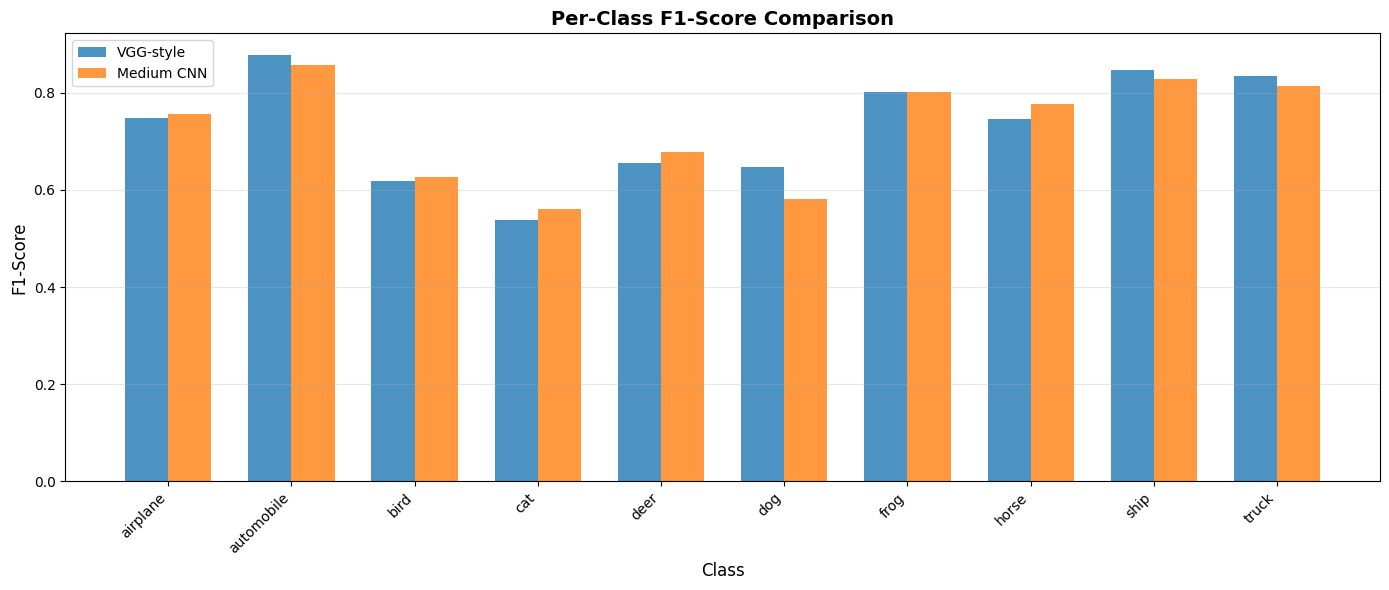

In [17]:
# Per-class accuracy comparison
from sklearn.metrics import precision_recall_fscore_support

precision1, recall1, f1_1, _ = precision_recall_fscore_support(y_true, pred_top1, average=None)
precision2, recall2, f1_2, _ = precision_recall_fscore_support(y_true, pred_top2, average=None)

comparison_per_class = pd.DataFrame({
    'Class': class_names,
    f'{top_model_1_name} - F1': f1_1,
    f'{top_model_2_name} - F1': f1_2,
    'Difference': f1_1 - f1_2
})

print("\n" + "="*80)
print("PER-CLASS F1-SCORE COMPARISON")
print("="*80)
print(comparison_per_class.to_string(index=False))
print("="*80)

# Visualize per-class comparison
x = np.arange(len(class_names))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, f1_1, width, label=top_model_1_name, alpha=0.8)
bars2 = ax.bar(x + width/2, f1_2, width, label=top_model_2_name, alpha=0.8)

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Per-Class F1-Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [18]:
# Extract CNN and MLP data
cnn_results = {k: v for k, v in results.items() if k != 'MLP'}
mlp_result = results['MLP']

# Comparison table
cnn_vs_mlp_data = []

# Add all CNNs
for name, data in cnn_results.items():
    cnn_vs_mlp_data.append({
        'Model Type': 'CNN',
        'Architecture': name,
        'Test Accuracy': f"{data['test_accuracy']:.4f}",
        'Accuracy (%)': f"{data['test_accuracy']*100:.2f}%",
        'Parameters': data['parameters'],
        'Parameters (formatted)': f"{data['parameters']:,}"
    })

# Add MLP
cnn_vs_mlp_data.append({
    'Model Type': 'MLP',
    'Architecture': 'MLP',
    'Test Accuracy': f"{mlp_result['test_accuracy']:.4f}",
    'Accuracy (%)': f"{mlp_result['test_accuracy']*100:.2f}%",
    'Parameters': mlp_result['parameters'],
    'Parameters (formatted)': f"{mlp_result['parameters']:,}"
})

df_cnn_vs_mlp = pd.DataFrame(cnn_vs_mlp_data)
df_cnn_vs_mlp = df_cnn_vs_mlp.sort_values('Parameters').reset_index(drop=True)

print("\n" + "="*100)
print("CNN vs MLP: COMPREHENSIVE COMPARISON")
print("="*100)
print(df_cnn_vs_mlp[['Model Type', 'Architecture', 'Accuracy (%)', 'Parameters (formatted)']].to_string(index=False))
print("="*100)

# Calculate efficiency metric: Accuracy per 1000 parameters
print("\nEFFICIENCY ANALYSIS (Accuracy % per 1000 parameters):")
print("-" * 80)
for _, row in df_cnn_vs_mlp.iterrows():
    acc = float(row['Test Accuracy'])
    params = row['Parameters']
    efficiency = (acc * 100) / (params / 1000)
    print(f"{row['Architecture']:20} - Efficiency: {efficiency:.4f}")
print("="*100)


CNN vs MLP: COMPREHENSIVE COMPARISON
Model Type       Architecture Accuracy (%) Parameters (formatted)
       CNN        LeNet-style       42.74%                 62,006
       CNN         Simple CNN       66.74%                167,562
       CNN         Medium CNN       73.04%                402,986
       CNN    Inception-style       52.99%                413,226
       CNN Deep CNN + Dropout       44.63%                845,738
       MLP                MLP       18.23%              1,738,890
       CNN          VGG-style       73.53%              2,228,426

EFFICIENCY ANALYSIS (Accuracy % per 1000 parameters):
--------------------------------------------------------------------------------
LeNet-style          - Efficiency: 0.6893
Simple CNN           - Efficiency: 0.3983
Medium CNN           - Efficiency: 0.1812
Inception-style      - Efficiency: 0.1282
Deep CNN + Dropout   - Efficiency: 0.0528
MLP                  - Efficiency: 0.0105
VGG-style            - Efficiency: 0.0330


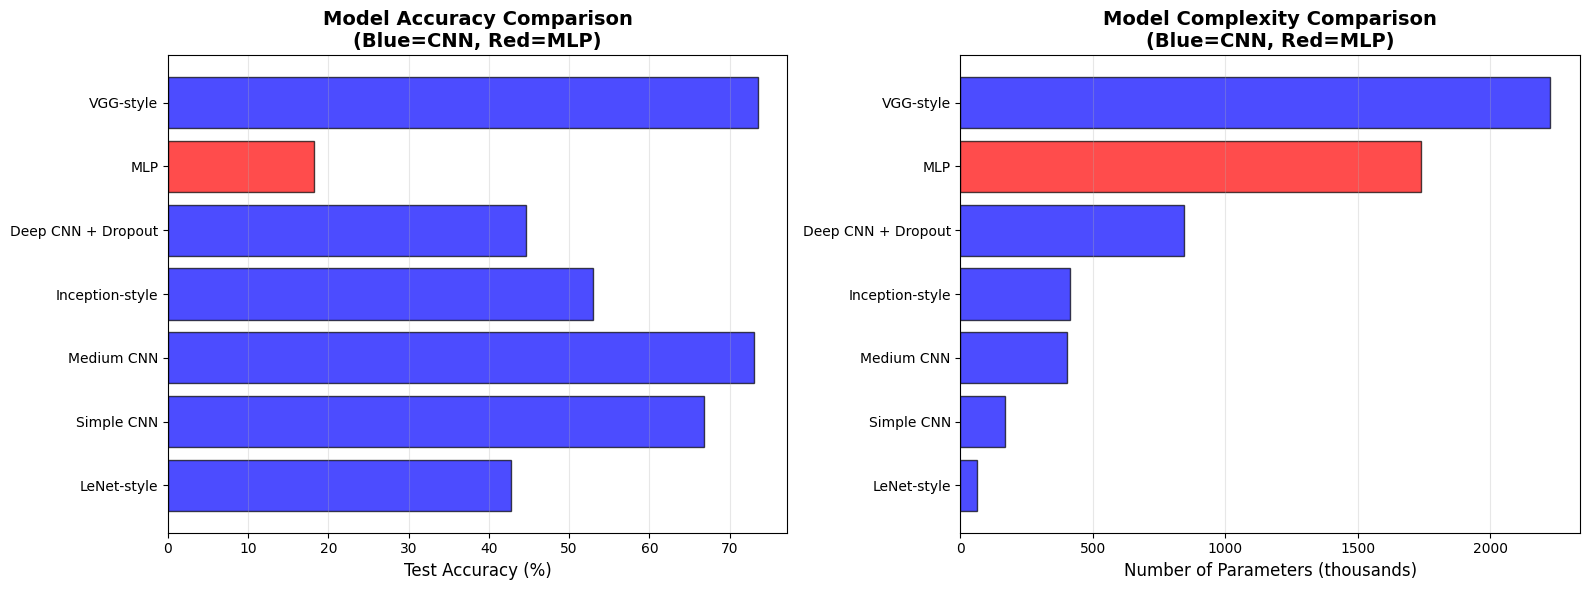


KEY INSIGHTS: CNN vs MLP

 Best CNN: VGG-style
   - Accuracy: 73.53%
   - Parameters: 2,228,426

 MLP:
   - Accuracy: 18.23%
   - Parameters: 1,738,890

 Comparison:
   - Best CNN is 55.30% more accurate than MLP
   - MLP has 0.78x MORE parameters than the best CNN
   - CNNs are more PARAMETER-EFFICIENT for image data!

 Conclusion:
   CNNs leverage spatial structure through convolution and pooling,
   achieving better accuracy with fewer parameters compared to MLPs.


In [19]:
# Visual comparison: CNN vs MLP
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy comparison
model_names = [row['Architecture'] for _, row in df_cnn_vs_mlp.iterrows()]
accuracies = [float(row['Test Accuracy'])*100 for _, row in df_cnn_vs_mlp.iterrows()]
colors_plot = ['blue' if t == 'CNN' else 'red' for t in df_cnn_vs_mlp['Model Type']]

axes[0].barh(model_names, accuracies, color=colors_plot, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Test Accuracy (%)', fontsize=12)
axes[0].set_title('Model Accuracy Comparison\n(Blue=CNN, Red=MLP)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Plot 2: Parameters comparison
params_plot = [row['Parameters']/1000 for _, row in df_cnn_vs_mlp.iterrows()]

axes[1].barh(model_names, params_plot, color=colors_plot, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Number of Parameters (thousands)', fontsize=12)
axes[1].set_title('Model Complexity Comparison\n(Blue=CNN, Red=MLP)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Key insights
print("\n" + "="*100)
print("KEY INSIGHTS: CNN vs MLP")
print("="*100)

best_cnn = max(cnn_results.items(), key=lambda x: x[1]['test_accuracy'])
best_cnn_name = best_cnn[0]
best_cnn_acc = best_cnn[1]['test_accuracy']
best_cnn_params = best_cnn[1]['parameters']

print(f"\n Best CNN: {best_cnn_name}")
print(f"   - Accuracy: {best_cnn_acc*100:.2f}%")
print(f"   - Parameters: {best_cnn_params:,}")

print(f"\n MLP:")
print(f"   - Accuracy: {mlp_result['test_accuracy']*100:.2f}%")
print(f"   - Parameters: {mlp_result['parameters']:,}")

print(f"\n Comparison:")
acc_diff = (best_cnn_acc - mlp_result['test_accuracy']) * 100
param_ratio = mlp_result['parameters'] / best_cnn_params

print(f"   - Best CNN is {acc_diff:.2f}% more accurate than MLP")
print(f"   - MLP has {param_ratio:.2f}x MORE parameters than the best CNN")
print(f"   - CNNs are more PARAMETER-EFFICIENT for image data!")

print("\n Conclusion:")
print("   CNNs leverage spatial structure through convolution and pooling,")
print("   achieving better accuracy with fewer parameters compared to MLPs.")
print("="*100)

Total misclassifications by VGG-style: 2647


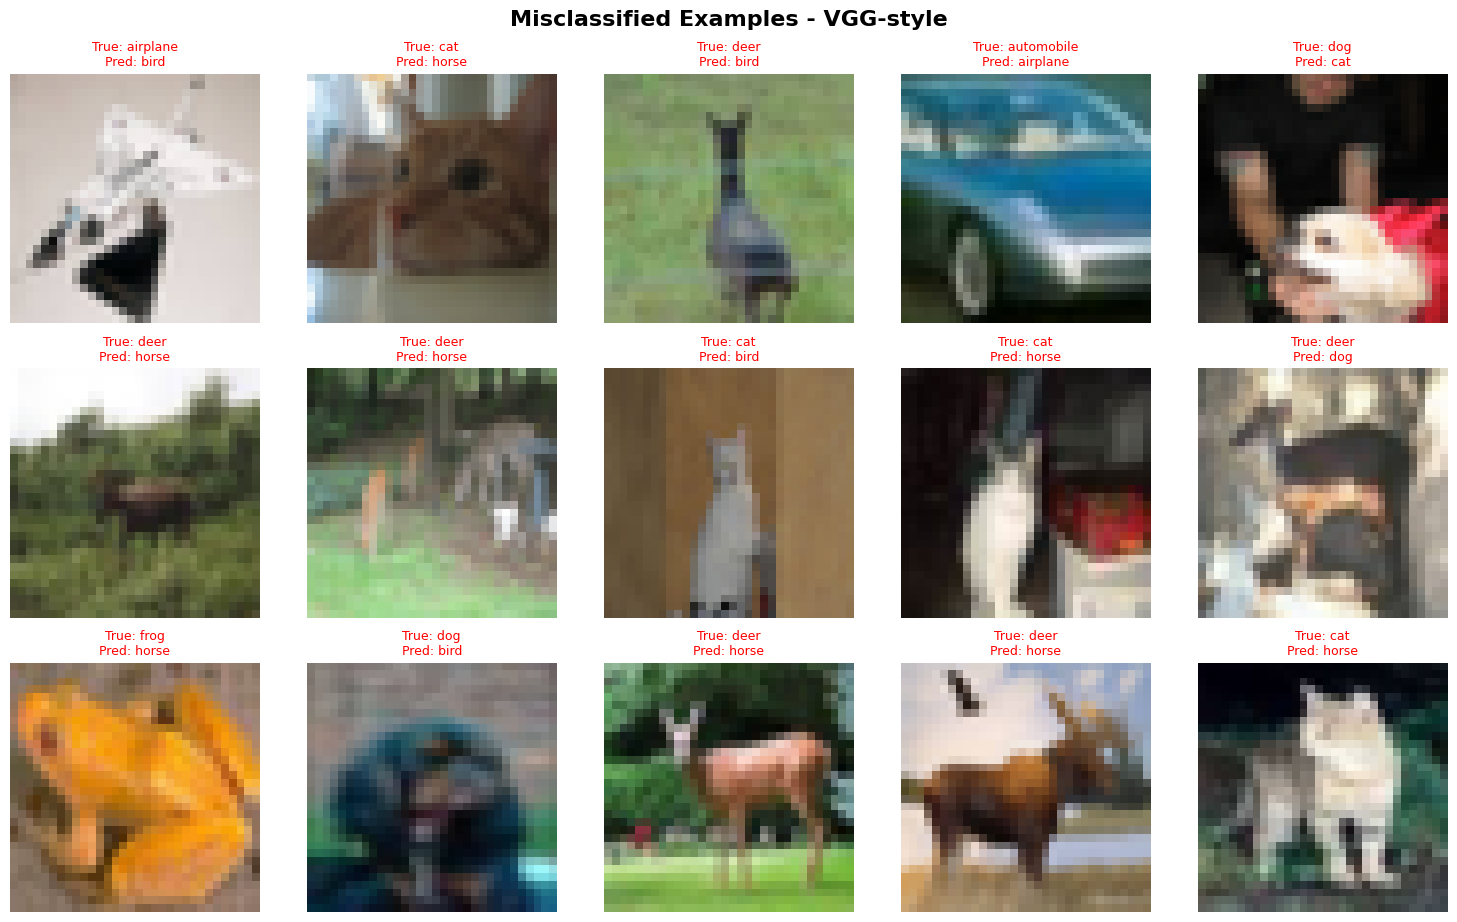

In [20]:
# Find misclassified examples for the best model
best_model_name = top_model_1_name
best_predictions = top_model_1_data['predictions']

# Find indices where prediction is wrong
misclassified_idx = np.where(best_predictions != y_true)[0]

print(f"Total misclassifications by {best_model_name}: {len(misclassified_idx)}")

# Show some misclassified examples
n_examples = 15
sample_idx = np.random.choice(misclassified_idx, min(n_examples, len(misclassified_idx)), replace=False)

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.ravel()

for i, idx in enumerate(sample_idx):
    axes[i].imshow(X_test[idx])
    true_label = class_names[y_true[idx]]
    pred_label = class_names[best_predictions[idx]]
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', fontsize=9, color='red')
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle(f'Misclassified Examples - {best_model_name}', fontsize=16, fontweight='bold', y=1.02)
plt.show()